<a href="https://colab.research.google.com/github/guylevin/color-classifier/blob/main/Classify_a_black_video_feed_using_Histogram_and_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify a black video feed using Histogram and Naive Bayes

### Importing the libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import math
from os import listdir
from os.path import isfile, join
import cv2
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
tf.__version__

'2.4.0'

## Data Preprocessing

### Getting the dataset ready

#### Connect to google drive to get the videos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Set consts

In [ ]:
black_videos="/content/drive/MyDrive/Colab Notebooks/Classify a black video feed/dataset/black"
normal_videos="/content/drive/MyDrive/Colab Notebooks/Classify a black video feed/dataset/normal"


frames_dir="/content/dataset/"
black_frames=join(frames_dir, "black_frames")
normal_frames=join(frames_dir, "normal_frames")

# !rm -r $frames_dir
!mkdir -p $black_frames $normal_frames

#### Extract Frames

In [ ]:
def split_videos_into_frames(input_dir, output_dir, image_index):
  video_files = [join(input_dir, f) for f in listdir(input_dir) if isfile(join(input_dir, f))]  

  for video_file in video_files:
    # print("Extracting frames from " + video_file)
    image_index = extract_frames(video_file, output_dir, image_index)

  return image_index

def extract_frames(video_file, output_dir, image_index):
  cap = cv2.VideoCapture(video_file)
  
  frame_rate = cap.get(cv2.CAP_PROP_FPS)    

  while(cap.isOpened()):
    ret, frame = cap.read()
    if (ret != True):
      break
    
    frame_possition = cap.get(cv2.CAP_PROP_POS_FRAMES)
    if (frame_possition % math.floor(frame_rate) == 0): # take 1 frame a second
      filename = join(output_dir, f'{image_index:05d}.jpg')
      # print(f'Writing frame {filename}')
      cv2.imwrite(filename, frame)
      image_index += 1

  cap.release()
  return image_index




In [ ]:
image_index=0
image_index = split_videos_into_frames(black_videos, black_frames, image_index)
image_index = split_videos_into_frames(normal_videos, normal_frames, image_index)

print(f"Extracted {image_index} images")

Extracted 3413 images


### Extracting Histogram

In [ ]:
# from matplotlib import pyplot as plt 

def image_to_histogram(image_file):
  img = cv2.imread(image_file)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  # hist=hist.T
  return hist


def tag_images(input_dir, tag):

  image_hists = []

  image_files = [join(input_dir, f) for f in listdir(input_dir) if isfile(join(input_dir, f))]  

  for image_file in image_files:
    image_hist = image_to_histogram(image_file)   
    image_hist = np.vstack((image_hist, tag)) 

    if not len(image_hists):
      image_hists = image_hist
    else:
      image_hists = np.hstack((image_hists, image_hist))  
  
  return image_hists


black_hists = tag_images(black_frames, 1) # black
normal_hists = tag_images(normal_frames, 0) # normal


Combine Data

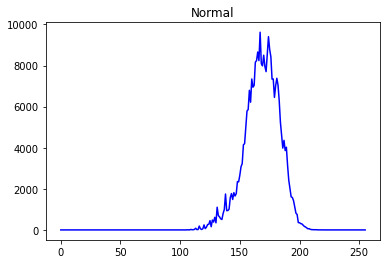

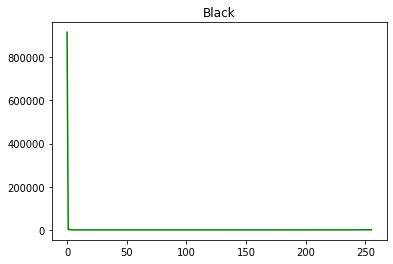

           0      1      2      3      4    ...     252     253     254     255  256
0          0.0    0.0    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0  0.0
1        161.0   42.0   53.0   59.0   90.0  ...  2547.0  4658.0  2775.0  1824.0  0.0
2         63.0   16.0   51.0   38.0   24.0  ...    74.0    78.0    67.0   571.0  0.0
3        321.0   17.0   20.0   18.0   27.0  ...   492.0  1095.0   796.0  6281.0  0.0
4        480.0   27.0   34.0   43.0   44.0  ...   469.0  1165.0   910.0  6558.0  0.0
...        ...    ...    ...    ...    ...  ...     ...     ...     ...     ...  ...
3408  918999.0  956.0  558.0  278.0  105.0  ...    23.0    56.0   111.0   457.0  1.0
3409  921120.0  205.0   88.0   44.0   19.0  ...     0.0     3.0     7.0   106.0  1.0
3410  921120.0  205.0   88.0   44.0   19.0  ...     0.0     3.0     7.0   106.0  1.0
3411  921120.0  205.0   88.0   44.0   19.0  ...     0.0     3.0     7.0   106.0  1.0
3412  921120.0  205.0   88.0   44.0   19.0  ...     0.0     3.0  

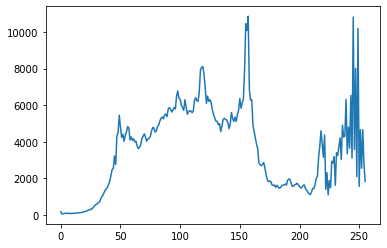

In [ ]:

plt.plot(normal_hists[:-1, 0], 'b') 
plt.title('Normal')
plt.show()

plt.plot(black_hists[:-1, 0], 'g') 
plt.title('Black')
plt.show()


all_hists = np.hstack((normal_hists, black_hists)).T
print(pd.DataFrame(all_hists))

plt.plot(all_hists[1, :-1].T) 
plt.show()

## Importing the dataset

In [ ]:
df = pd.DataFrame(all_hists)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

## Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
print(X_train)

[[1.4400e+02 4.6000e+01 4.4000e+01 ... 4.4000e+01 1.3000e+01 2.2500e+02]
 [1.0100e+02 1.7000e+01 2.4000e+01 ... 2.7200e+02 2.3900e+02 2.6220e+03]
 [3.6300e+02 5.1000e+01 6.5000e+01 ... 3.5190e+03 4.1600e+03 2.3661e+04]
 ...
 [3.5600e+02 4.2000e+01 3.6000e+01 ... 3.3840e+03 5.5230e+03 8.0710e+03]
 [5.9000e+02 7.0000e+01 7.0000e+01 ... 3.5000e+02 3.3000e+01 9.3400e+02]
 [7.8000e+01 3.2000e+01 4.0000e+01 ... 3.4500e+02 2.2700e+02 1.1150e+03]]


In [ ]:
print(y_train)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(X_test)

[[4.4300e+02 5.1000e+01 5.9000e+01 ... 1.8500e+02 1.1300e+02 9.9600e+02]
 [9.2112e+05 2.0500e+02 8.8000e+01 ... 3.0000e+00 7.0000e+00 1.0600e+02]
 [1.1200e+03 2.1100e+02 2.2900e+02 ... 8.0470e+03 1.7499e+04 9.5372e+04]
 ...
 [3.6000e+01 1.4000e+01 3.5000e+01 ... 4.6100e+02 3.3700e+02 2.1720e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [1.1100e+02 3.0000e+01 3.1000e+01 ... 2.4380e+03 1.5050e+03 1.2129e+04]]


In [ ]:
print(y_test)

[0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.

## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
print(X_train)

[[-0.34440101 -0.24722569 -0.21647579 ... -0.60842765 -0.38291023
  -0.47552345]
 [-0.34455315 -0.36997429 -0.28346674 ... -0.51810893 -0.34859651
  -0.39709269]
 [-0.34362613 -0.22606214 -0.1461353  ...  0.76814053  0.24673134
   0.29131151]
 ...
 [-0.3436509  -0.26415653 -0.24327217 ...  0.71466234  0.45367647
  -0.2187993 ]
 [-0.34282295 -0.14564064 -0.12938756 ... -0.48721042 -0.37987362
  -0.4523247 ]
 [-0.34463453 -0.30648364 -0.22987398 ... -0.48919109 -0.35041848
  -0.44640231]]


In [ ]:
print(X_test)

[[-0.34334307 -0.22606214 -0.16623258 ... -0.55257265 -0.36772717
  -0.45029603]
 [ 2.91423659  0.42577528 -0.06909571 ... -0.62466917 -0.38382121
  -0.47941718]
 [-0.34094768  0.45117154  0.40319049 ...  2.56183858  2.27199993
   2.63772311]
 ...
 [-0.34478314 -0.38267243 -0.24662172 ... -0.44323947 -0.33371711
  -0.41181686]
 [-0.34491051 -0.44193037 -0.36385588 ... -0.62546144 -0.38488403
  -0.48288554]
 [-0.34451777 -0.31494906 -0.26001991 ...  0.33991889 -0.15637895
  -0.08601998]]


## Training the Naive Bayes model on the Training set

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Predicting the Test set results

In [ ]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [1. 1.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


## Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[753   0]
 [  0 101]]


1.0

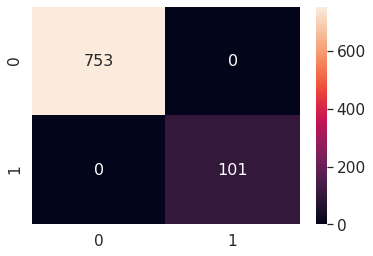

In [ ]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size

plt.show()

## Save the classifier and scaller

In [ ]:
models_directory="/content/drive/MyDrive/Colab Notebooks/Classify a black video feed/models/hist/"
model_file = join(models_directory, 'model.pkl')
scaler_file = join(models_directory, 'scaler.pkl')

In [ ]:
from pickle import dump

# save the model
dump(classifier, open(model_file, 'wb'))
# save the scaler
dump(sc, open(scaler_file, 'wb'))

## Predicting a new result

In [ ]:
from pickle import load

# load the model
model = load(open(model_file, 'rb'))
# load the scaler
scaler = load(open(scaler_file, 'rb'))

image_to_predict = '/content/drive/MyDrive/Colab Notebooks/Classify a black video feed/Test Images/black.png'

hist = image_to_histogram(image_to_predict)

result = classifier.predict(sc.transform(hist.T))
print(result)

if result[0] == 1:
   prediction = 'black'
else:
   prediction = 'normal'

print(prediction)

[1.]
black
